# Обучение

Даны следующие файлы:


assessments.csv — этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).

code_module — идентификационный код предмета.

code_presentation — семестр (Идентификационный код).

id_assessment — тест (Идентификационный номер ассессмента).

assessment_type — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).

date — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).

weight — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

courses.csv — файл содержит список предметов по семестрам.

code_module — предмет (идентификационный код).

code_presentation — семестр (идентификационный код).

module_presentation_length — продолжительность семестра в днях.

studentAssessment.csv — этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.
id_assessment — тест (идентификационный номер).

id_student — идентификационный номер студента.

date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

is_banked — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

score — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

studentRegistration.csv — этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.
code_module — предмет (идентификационный код).

code_presentation — семестр (идентификационный код)

id_student — идентификационный номер студента.

date_registration — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).

date_unregistration — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

In [1]:
import pandas as pd
import requests
#import numpy as np
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

pass_courses = 'https://disk.yandex.ru/d/jmJxR8yhwCXlaw'
pass_assessments = 'https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'
pass_studentAssessment = 'https://disk.yandex.ru/d/DYd4M5b_8RETsA'
pass_studentRegistration = 'https://disk.yandex.ru/d/lqHnH8NOZ458iw'



# courses -  список предметов по семестрам
query = requests.get(url + urlencode(dict(public_key = pass_courses)))
courses = pd.read_csv(query.json()['href'])

# assessments - информация об оценках в тесте
query = requests.get(url + urlencode(dict(public_key = pass_assessments)))
assessments = pd.read_csv(query.json()['href'])

# stAss - результаты тестов студентов
query = requests.get(url + urlencode(dict(public_key = pass_studentAssessment)))
stAss = pd.read_csv(query.json()['href']) 

# stReg - информация о регистрации студентов на курсы
query = requests.get(url + urlencode(dict(public_key = pass_studentRegistration)))
stReg = pd.read_csv(query.json()['href']) 



### Предварительный анализ данных

Курс - это уникальное сочетание идентификационного кода предмета (code_module) и идентификационного кода семестра (code_presentation).  Курс включает тесты ТМА, иногда -  СМА, и заканчивается экзаменом (Exam), при этом сумма weight всех тестов(ТМА и СМА) должна быть равна 100. Например: AAA	2013J - это один курс, а AAA 2014J - это другой курс. 


У курсов CCC 2014B и CCC 2014J по два экзамена в таблице assessments, но после объединения таблиц - в сводной таблице sv, экзаменов с кодами 40087 и 40088 нет и данные курсы тоже подходят под вышенаписанное определение.

In [3]:
assessments[:12]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
5,AAA,2013J,1757,Exam,NaN,100.0
6,AAA,2014J,1758,TMA,19.0,10.0
7,AAA,2014J,1759,TMA,54.0,20.0
8,AAA,2014J,1760,TMA,117.0,20.0
9,AAA,2014J,1761,TMA,166.0,20.0


In [4]:
assessments.isna().sum() 

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [5]:
assessments.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object

In [6]:
# пустые значения есть только в колонке date - окончательная  дата сдачи теста, 
# выясним у каких конкретно типов теста (оценка преподавателя (TMA), компьютерная (СМА), экзамен по курсу (Exam))

assessments.loc[assessments.date.isnull()].assessment_type

5      Exam
11     Exam
23     Exam
35     Exam
47     Exam
53     Exam
62     Exam
63     Exam
72     Exam
73     Exam
108    Exam
Name: assessment_type, dtype: object

In [7]:
# для выполнения заданий данного проекта экзамены критичны, поэтому удалять строки с пустыми значениями не будем,
# а заполним пустые значения колонки date, для этого объединим таблицы courses и assessments. 

courses_assessments = assessments.merge(courses, on = ['code_module','code_presentation'])
courses_assessments.query("assessment_type == 'Exam' & date.notnull()")

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length
87,DDD,2013B,25340,Exam,240.0,100.0,240
94,DDD,2013J,25354,Exam,261.0,100.0,261
101,DDD,2014B,25361,Exam,241.0,100.0,241
113,EEE,2013J,30713,Exam,235.0,100.0,268
118,EEE,2014B,30718,Exam,228.0,100.0,241
123,EEE,2014J,30723,Exam,235.0,100.0,269
136,FFF,2013B,34872,Exam,222.0,100.0,240
149,FFF,2013J,34885,Exam,236.0,100.0,268
162,FFF,2014B,34898,Exam,227.0,100.0,241
175,FFF,2014J,34911,Exam,241.0,100.0,269


In [8]:
# Проведя анализ мы видим что date <= module_presentation_length для строк с assessment_type == 'Exam'
# принимаем решение заполнить пустые date из  колонки module_presentation_length

courses_assessments['date'] = courses_assessments\
                           .apply(lambda x: x['date'] if x['date'] > 0 else x['module_presentation_length'], axis = 1)

In [9]:
# объединяем courses_assessments с оставшимися таблицами и получаем общую таблицу sv

sv = courses_assessments.merge(stAss, on = 'id_assessment')
sv = sv.merge(stReg, on = ['code_module', 'code_presentation', 'id_student'])\
                        .sort_values(['code_module', 'code_presentation', 'id_student'])
sv.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,id_student,date_submitted,is_banked,score,date_registration,date_unregistration
0,AAA,2013J,1752,TMA,19.0,10.0,268,11391,18,0,78.0,-159.0,NaN
1,AAA,2013J,1753,TMA,54.0,20.0,268,11391,53,0,85.0,-159.0,NaN
2,AAA,2013J,1754,TMA,117.0,20.0,268,11391,115,0,80.0,-159.0,NaN
3,AAA,2013J,1755,TMA,166.0,20.0,268,11391,164,0,85.0,-159.0,NaN
4,AAA,2013J,1756,TMA,215.0,30.0,268,11391,212,0,82.0,-159.0,NaN


In [10]:
# отсортируем по типу теста Exam и посмотрим распределение студентов по курсам
# в предоставленных данных экзаменами заканчиваются только шесть курсов. 

sv.query("assessment_type == 'Exam'")\
  .groupby(['code_module', 'code_presentation', 'id_assessment'])\
  .agg({'id_student' : 'count'})

id_student
code_module code_presentation id_assessment            
CCC         2014B             24290                 747
            2014J             24299                1168
DDD         2013B             25340                 602
            2013J             25354                 968
            2014B             25361                 524
            2014J             25368                 950

In [11]:
# Проанализировав задания, делаем вывод, что нам нужны только данные по экзаменам.
# (подробные рассуждения приведены в конце работы)

exam = sv.loc[sv.assessment_type == 'Exam'].copy()

In [12]:
exam

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,id_student,date_submitted,is_banked,score,date_registration,date_unregistration
47117,CCC,2014B,24290,Exam,241.0,100.0,241,29764,230,0,94.0,-34.0,NaN
47126,CCC,2014B,24290,Exam,241.0,100.0,241,29820,230,0,76.0,-57.0,NaN
47133,CCC,2014B,24290,Exam,241.0,100.0,241,40604,234,0,66.0,-17.0,NaN
47142,CCC,2014B,24290,Exam,241.0,100.0,241,42638,230,0,50.0,-52.0,NaN
47154,CCC,2014B,24290,Exam,241.0,100.0,241,46605,230,0,98.0,-54.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90904,DDD,2014J,25368,Exam,262.0,100.0,262,2677210,243,0,71.0,-109.0,NaN
90911,DDD,2014J,25368,Exam,262.0,100.0,262,2678380,242,0,64.0,-127.0,NaN
90924,DDD,2014J,25368,Exam,262.0,100.0,262,2684043,243,0,69.0,-42.0,NaN
90931,DDD,2014J,25368,Exam,262.0,100.0,262,2685863,243,0,49.0,-136.0,NaN


In [13]:
exam.shape

(4959, 13)

In [14]:
exam.isna().sum()
# пустые значения только у даты отмены регистрации, что соответствует окончанию курса

code_module                      0
code_presentation                0
id_assessment                    0
assessment_type                  0
date                             0
weight                           0
module_presentation_length       0
id_student                       0
date_submitted                   0
is_banked                        0
score                            0
date_registration                0
date_unregistration           4958
dtype: int64

In [15]:
exam[['is_banked', 'score', 'date_registration', 'date_submitted']].describe()

,is_banked,score,date_registration,date_submitted
count,4959.0,4959.000000,4959.000000,4959.000000
mean,0.0,65.572898,-72.248639,238.483565
std,0.0,20.579186,51.168107,5.717577
min,0.0,0.000000,-310.000000,229.000000
25%,0.0,51.000000,-102.000000,234.000000
50%,0.0,67.000000,-58.000000,241.000000
75%,0.0,82.000000,-30.000000,243.000000
max,0.0,100.000000,101.000000,285.000000


- оценок отрицательных и больше 100 баллов - нет, но есть оценки равные 0 баллов
- пересдач - нет
- дата регистрации - в среднем за 72 дня до начала курса, меньше 25%  зарегистрировались после начала курса
- дата сдачи теста - стандартное отклонение около 6 дней

In [16]:
exam.dtypes

code_module                    object
code_presentation              object
id_assessment                   int64
assessment_type                object
date                          float64
weight                        float64
module_presentation_length      int64
id_student                      int64
date_submitted                  int64
is_banked                       int64
score                         float64
date_registration             float64
date_unregistration           float64
dtype: object

In [17]:
exam.query("date_unregistration.notnull()")
# у одного экзамена стоит дата отмены регистрации, при этом экзамен сдан, будем считать это технической ошибкой

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,id_student,date_submitted,is_banked,score,date_registration,date_unregistration
81535,DDD,2013J,25354,Exam,261.0,100.0,261,425543,237,0,33.0,-39.0,232.0


In [18]:
exam.query("module_presentation_length < date_submitted")
# несколько сдавших экзамен после окончания семестра, удалять эти строки не будем, они потребуются в шестом задании

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,id_student,date_submitted,is_banked,score,date_registration,date_unregistration
47474,CCC,2014B,24290,Exam,241.0,100.0,241,169380,242,0,78.0,-34.0,NaN
49948,CCC,2014B,24290,Exam,241.0,100.0,241,555008,266,0,56.0,-46.0,NaN
50528,CCC,2014B,24290,Exam,241.0,100.0,241,577245,243,0,34.0,-25.0,NaN
60001,CCC,2014J,24299,Exam,269.0,100.0,269,555498,285,0,58.0,-129.0,NaN
66932,DDD,2013B,25340,Exam,240.0,100.0,240,81351,248,0,0.0,-12.0,NaN
71964,DDD,2013B,25340,Exam,240.0,100.0,240,532491,241,0,49.0,-120.0,NaN
72390,DDD,2013B,25340,Exam,240.0,100.0,240,538611,241,0,51.0,-82.0,NaN
73363,DDD,2013B,25340,Exam,240.0,100.0,240,548535,241,0,60.0,-24.0,NaN
84013,DDD,2014B,25361,Exam,241.0,100.0,241,391924,251,0,69.0,-93.0,NaN
86965,DDD,2014B,25361,Exam,241.0,100.0,241,631388,242,0,78.0,-15.0,NaN


In [19]:
exam.query("date_registration >= date_submitted")
# проверяем нет ли ошибок в датах

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,id_student,date_submitted,is_banked,score,date_registration,date_unregistration


## Выполнение заданий

#### 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене).

Сначала посмотрим, есть ли студенты сдававшие один и тот же курс больше одного раза, для этого сгруппируем наши данные по курсу (исходя из нашего определения курса -по code_module и code_presentation) и индентификационному номеру студента. 

In [20]:
exam.groupby(['code_module', 'code_presentation', 'id_student'])\
    .agg({'assessment_type' : 'count'})\
    .sort_values('assessment_type')

assessment_type
code_module code_presentation id_student                 
CCC         2014B             29764                     1
DDD         2013J             604317                    1
                              604281                    1
                              604156                    1
                              604072                    1
...                                                   ...
CCC         2014J             679886                    1
                              679750                    1
                              679733                    1
                              680133                    1
DDD         2014J             2689863                   1

[4959 rows x 1 columns]

Таких студентов нет, поэтому сгруппировав данные по индентификационному номеру студента можно подсчитать количество успешно сданных экзаменов у каждого студента и отобрать строки где успешно сдан только один.

In [21]:
# оценка ниже 40 по условию - это неуспешная сдача экзамена, сделаем колонку успешных сдач 
# колонка success  будет содержать 1, если экзамен успешен и 0 - если нет

exam['success'] = exam['score'].apply(lambda x: 1 if x >= 40 else 0)

In [22]:
exam_success = exam.groupby(['id_student']).agg({"success" : 'sum'})
success = len(exam_success.loc[exam_success['success'] == 1])

In [23]:
success

3802

Ответ: 3802 студента успешно сдали только один курс

#### 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью

завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [24]:
# исходя из нашего определения курса, группируем по code_module и code_presentation
# колонка success  содержит 1, если экзамен успешен и 0 - если нет, поэтому найдя среднее  success получаем завершаемость
exam_end = exam.groupby(['code_module', 'code_presentation', 'id_assessment']).agg({'success' : 'mean'})
# колонку success отобразим в процентах 
exam_end['success'] = round(exam_end.success * 100, 1).astype('str') + '%'

In [25]:
exam_end

success
code_module code_presentation id_assessment        
CCC         2014B             24290           88.9%
            2014J             24299           87.2%
DDD         2013B             25340           83.7%
            2013J             25354           90.7%
            2014B             25361           92.6%
            2014J             25368           88.6%

In [26]:
exam_end.success.idxmax()

('DDD', '2014B', 25361)

In [27]:
exam_end.success.idxmin()

('DDD', '2013B', 25340)

Ответ: самый сложный экзамен - 25340, курс с самой низкой завершаемостью - DDD 2013B\
       самый легкий экзамен - 25361, курс с самой высокой завершаемостью - DDD 2014B 

*Если посчитать разницу в процентах между самым сложным и самым легким получится 9%, мне кажется разница достаточно маленькая и экзамены примерно одинаковы по сложности.


#### 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

In [28]:
# определим средний срок по предмету - code_module 
# округлим получившееся среднее до целого для лучшей визулизации

df = round(exam.query('success == 1').groupby('code_module', as_index = False).agg({'date_submitted' : 'mean'}))

In [29]:
# переименовываем колонку,содержащую средний срок сдачи экзамена

df = df.rename(columns = {'date_submitted' : 'date_submitted_average'})

In [30]:
df

,code_module,date_submitted_average
0,CCC,239.0
1,DDD,238.0


#### 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3)

В данном задании надо определить популярность (отток) предмета среди студентов, независимо от того были ли получены оценки за этот предмет, поэтому возьмем таблицу  stReg с первоначальными данными о регистрации/отмене регистрации студентов на курсы.

Популярность предмета - это сколько уникальных студентов записалось на этот предмет, если студент записался на один и тот же предмет несколько раз, то популярнее в среде студентов этот предмет не становится. Аналогично по оттоку.


Чтобы выполнить это задание, нам надо группировать данные по предмету - code_module, а не по курсу (code_module и code_presentation) и считать количество регистраций (для популярных) уникальных студентов.

In [64]:
stReg.isna().sum()

code_module                     0
code_presentation               0
id_student                      0
date_registration              45
date_unregistration         22521
date_unregistration_bool        0
dtype: int64

In [66]:
# добавим столбец, в котором значению NaN столбца date_unregistration будет соответствовать True, остальным значениям - False
stReg['date_unregistration_bool'] = stReg.date_unregistration.isna()

In [67]:
# чтобы получить корректный результат по количеству регистраций удалим строки с пустыми датами регистрации

stReg_reg = stReg.loc[stReg.date_registration.notnull()]

In [68]:
stReg_code_reg = stReg_reg.groupby(['code_module'], as_index = False)\
                   .id_student.nunique()\
                   .sort_values('id_student',ascending = False )

Text(0, 0.5, 'count')

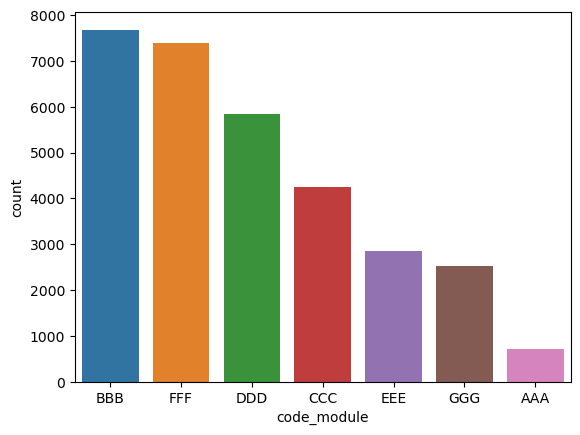

In [69]:
sns.barplot(x = 'code_module', y = 'id_student', data = stReg_code_reg)
plt.ylabel("count")

Будем работать с полученным датафреймом stReg_reg, т.к. отток есть смысл определять по зарегистрировавшимся студентам.
Для подсчета оттока будем учитывать тот факт, что студенты могут повторно зарегистрироваться на предмет после отмены предыдущей регистрации, т.е. нас интересуют студенты, у которых по конкретному предмету нет пустых дат отмен регистрации (пустая дата = закончили курс).
 

In [36]:
# сгруппировав по студентам и предметам, найдем сумму по колонке date_unregistration_bool. Если она равна нулю, то значит у данной
# пары студент-предмет нет пустой даты отмены регистрации - студент не стал закончивать предмет, далее считаем отток студентов по предметам
stReg_unreg = stReg_reg.groupby(['id_student','code_module'], as_index = False)\
                       .date_unregistration_bool.sum()\
                       .query('date_unregistration_bool == 0')\
                       .groupby(['code_module'], as_index = False)\
                       .id_student.nunique().sort_values('id_student',ascending = False )

Найдем процент оттока по каждому предмету

In [37]:
# переименуем колонки
stReg_code_reg = stReg_code_reg.rename(columns = {'id_student' : 'count_reg'})
stReg_unreg = stReg_unreg.rename(columns = {'id_student' : 'count_unreg'})

# объединим датафреймы
stReg_code_reg_unreg = stReg_code_reg.merge(stReg_unreg, on = 'code_module')

# посчитаем процент оттока по каждому предмету
stReg_code_reg_unreg['reg_unreg'] = round(stReg_code_reg_unreg.count_unreg / stReg_code_reg_unreg.count_reg * 100,2)

Text(0, 0.5, '% оттока')

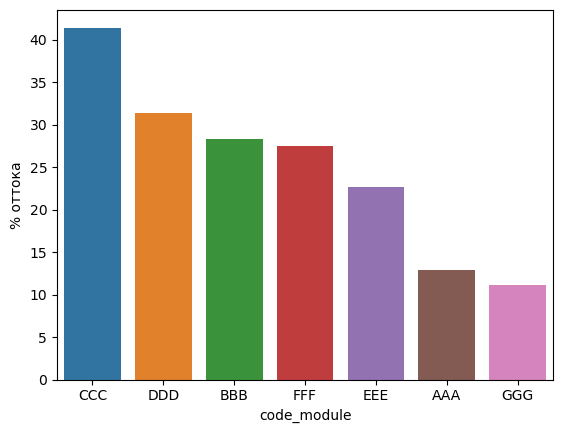

In [74]:
sns.barplot(x = 'code_module', y = 'reg_unreg', data = stReg_code_reg_unreg.sort_values('reg_unreg',ascending = False ))
plt.ylabel("% оттока")

Ответ:ТОП-3 популярных предметов BBB, FFF, DDD. ТОП-3 по оттоку - CCC, DDD, BBB

#### 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов

завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [79]:
# завершаемость также можно посчитать усреднившись по полю success (где проставлены 0/1 в зависимости от успешности сдачи).
exam_sem = exam.groupby(['code_presentation'])\
             .agg({"success" : 'mean','date_submitted' : 'mean'})

In [80]:
exam_sem

,success,date_submitted
code_presentation,,
2013B,0.837209,230.179402
2013J,0.907025,239.505165
2014B,0.904013,232.988985
2014J,0.878659,243.674221


In [81]:
exam_sem.success.idxmin()

'2013B'

In [82]:
exam_sem.date_submitted.idxmax()

'2014J'

Ответ: семестр с самой низкой завершаемостью курсов 2013B. Семестр с самыми долгими средними сроками сдачи 2014J

#### 6.Построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 

Метод RFM, в основном, успешно используется маркетологами и анализирует поведение клиентов по трем параметрам:\
R - насколько недавней является последняя покупка клиента,\
F - как часто клиент совершает покупку,\
M - сколько денег тратит клиент.\
Чтобы получить оценку RFM клиента, нужно сначала вычислить оценки R, F и M по шкале от 1 (худший результат) до 5 (лучший результат).

Адаптируем это метод для качественной оценки студентов.

Выберем следующие метрики:\
R - относительное среднее время сдачи одного экзамена,\
F - завершаемость курсов,\
M - среднее количество баллов, получаемое за экзамен.

Каждый сегмент должен иметь понятные характеристики описывающие студентов.

Среднее время сдачи одного экзамена, используемое в наших данных, измеряется как количество дней с начала семестра. Разбить эти данные на группы возможно, но непонятен их смысл для описания характеристики студентов: "студенты сдавшие экзамены в диапазоне с 234 по 240 день" - это плохо или хорошо, как дальше работать с этой информацией?\
Поэтому найдем средний срок сдачи каждого курса и уже относительно него будем считать среднее время сдачи данного курса у студентов - относительный средний срок сдачи курса - метрика R.


In [226]:
# найдем средний срок сдачи для каждого курса 
avg = exam.groupby(['code_module','code_presentation']).agg({'date_submitted' : 'mean'})

#переименнуем колонку, чтобы при объединении таблиц  названия колонок были понятнее
avg = avg.rename(columns={'date_submitted' : 'date_avg'})

# объединим таблицы 
exam_st = exam.merge(avg, on = ['code_module','code_presentation'])

# теперь можем найти разницe между средним сроком сдачи курса и фактической сдачей курса,
exam_st['data_ras'] = exam_st.apply(lambda x: (x['date_avg'] - x['date_submitted']),axis = 1)

In [227]:
# группируем по индификационному коду студента и считаем:
# - среднее отклонение сдачи экзаменов каждого студента от среднего срока сдачи курса,
# - среднее количество баллов,
# - завершаемость
exam_st = exam_st.groupby('id_student', as_index = False)\
               .agg({'data_ras' : 'mean' ,'score' : 'mean',"success" : 'mean'})\
# переименовываем колонки
exam_st = exam_st.rename(columns = {'data_ras' : 'data_ras_avg'})
exam_st = exam_st.rename(columns = {'score' : 'score_avg'})
exam_st = exam_st.rename(columns = {'success' : 'end'})

Определяем интервалы метрик.

In [229]:
# посмотрим на даты сдачи каждого курса -  есть только один студент сдавший раньше основного потока, остальные или в основные дни, или позже

exam.groupby(['code_module','code_presentation','date_submitted']).agg({'id_student':'count'})

id_student
code_module code_presentation date_submitted            
CCC         2014B             230                    481
                              234                    222
                              236                     30
                              237                      9
                              238                      2
                              242                      1
                              243                      1
                              266                      1
            2014J             243                    170
                              244                    721
                              245                    203
                              248                     46
                              249                      1
                              250                     13
                              251                      5
                              252                      5
                              256                      1
                              259                      2
                              285                      1
DDD         2013B             229                    179
                              230                    240
                              231                    152
                              233                     25
                              234                      1
                              235                      1
                              241                      3
                              248                      1
            2013J             236                      1
                              237                    449
                              241                    227
                              242                    264
                              243                     17
                              244                      2
                              245                      5
                              248                      1
                              250                      1
                              255                      1
            2014B             234                    299
                              236                    209
                              237                      8
                              238                      5
                              242                      2
                              251                      1
            2014J             242                    383
                              243                    488
                              244                     54
                              245                     14
                              248                      2
                              249                      5
                              250                      2
                              256                      1
                              279                      1

Проанализировав сроки сдачи экзаменов студентами мы видим, что основная сдача экзамена идет в течении двух - шести дней, поэтому задаем интервалы метрики R:\
3 - те, кто сдал +- 3 дня от средней, т.е. основная сдача,\
2 - те, кто сдал в ближайшие дни, + 7 от средней,\
1 - те, кто сдал сильно позже всех, от 7 дней и более.

In [230]:
# посмотрим какие значения принимает колонка - завершаемость курсов
exam_st['end'].value_counts()

end
1.0    4069
0.0     536
0.5      28
Name: count, dtype: int64

Завершаемость курсов в анализируемых данных принимает только три значения - 0, 0.5 и 1, поэтому для метрики F будем использовать соответствующие им значения 1, 2 и 3:\
1 - не завершен ни один курс\
2 - завершена половина курсов\
3 - завершены все курсы

In [231]:
# определяем крайние значения для метрики М -среднее количество баллов за экзамен
# минимальное
exam_st['score_avg'].min()

0.0

In [232]:
# максимальное
exam_st['score_avg'].max()

100.0

Для метрики М установим следующие значения:\
1 - до 40 баллов - это студенты, получившие неудовлетворительные оценки на экзамене,\
2 - с 40 до 80 баллов - студенты со средней успеваемостью,\
3 - выше 80 - отличники.\
Если мы поделим средние оценки на  интервалы по частоте встречаемости, то интерпретировать результаты будет затруднительно.

In [240]:
# присваиваем метрикам ранги от 1 до 3, от худшего к лучшему
# R: 1 - больше 7 дней от средней, 2 - + 7 дня от средней, 3 - +- 3 дня от средней
# F: 1 - не завершен ни один курс, 2 - завершена половина курсов, 3 - завершены все курсы
# М: 1 - до 40 баллов, 2 - с 40 до 80 баллов,3 - выше 80

exam_st['R'] = exam_st['data_ras_avg'].apply(lambda x: 1 if x < -7 else  3 if x >=  -3 else 2)
exam_st['F'] = exam_st['end'].apply(lambda x: 2 if x==0.5 else  3 if x == 1 else 1)
exam_st['M'] = exam_st['score_avg'].apply(lambda x: 1 if x<40 else  3 if x >= 80 else   2)

Проведем небольшой анализ получившихся метрик

In [241]:
exam_st.R.value_counts(normalize = True).mul(100)
# примено 97% студентов сдают экзамены в основном потоке

R
3    96.654436
2     2.805957
1     0.539607
Name: proportion, dtype: float64

In [242]:
exam_st.M.value_counts(normalize = True).mul(100) 
# примено 12% студентов сдают экзамены неудовлетворительно

M
2    59.939564
3    28.340168
1    11.720268
Name: proportion, dtype: float64

Построим графики

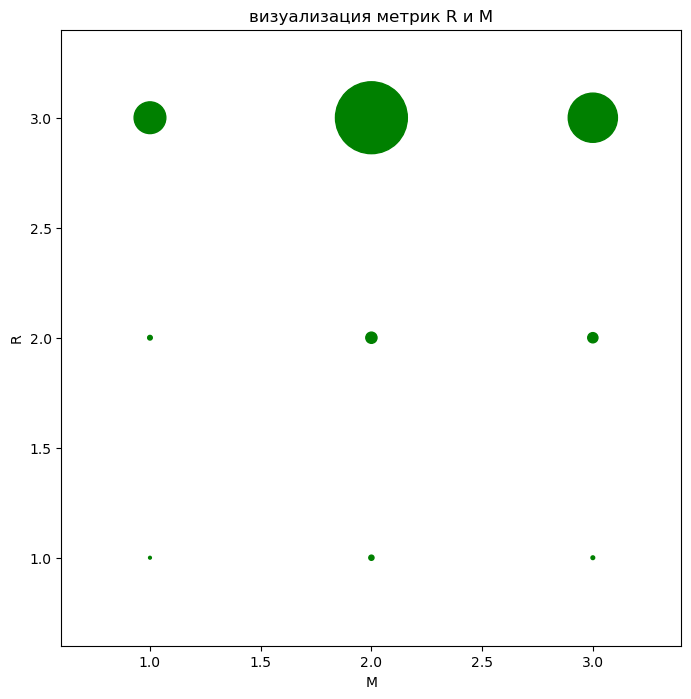

In [243]:
rfm = exam_st.groupby(['R','F','M'], as_index = False).id_student.count()

plt.figure(figsize = (8,8))
plt.scatter(rfm.M, rfm.R, s = rfm.id_student, c = 'g')
plt.ylim(0.6,3.4)
plt.xlim(0.6,3.4)

plt.title("визуализация метрик R и M")
plt.xlabel("M")
plt.ylabel("R")
plt.show()

Больше всего студентов учатся на средние баллы и сдают экзамены в основном потоке, отличников больше, чем тех, кто учится на неудовлетворительные оценки. Сдающих экзамены не вовремя, независимо от оценки, очень мало.

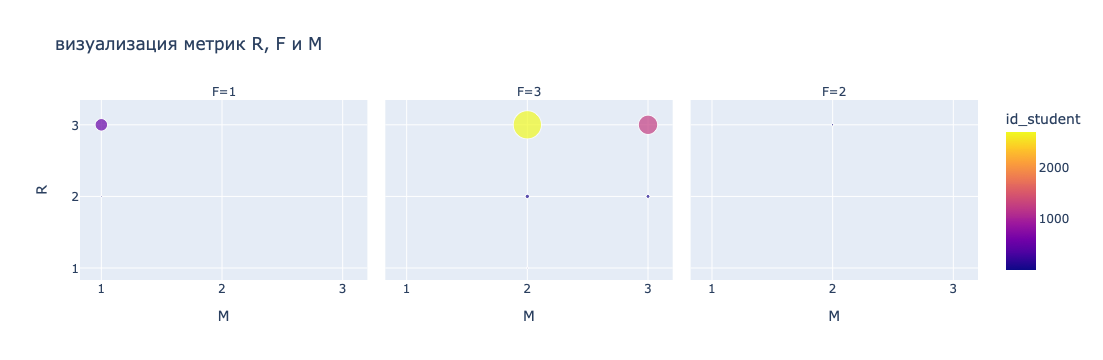

In [244]:
fig = px.scatter(rfm , x = "M", y = "R", color = "id_student", size = "id_student", facet_col = "F", title = 'визуализация метрик R, F и M')
fig.update_xaxes(dtick = 1) #делаем шаг оси равный 1
fig.update_yaxes(dtick = 1) #делаем шаг оси равный 1
fig.show()

На этом графике видна взаимосвязь уже трех метрик, но маленькие значения тут совсем не визуализируются.

In [245]:
# сгруппируем всех студентов по RFM кластерам
exam_st['RFM'] = exam_st['R'].map(str) + exam_st['F'].map(str) + exam_st['M'].map(str)
rfm = exam_st.groupby('RFM', as_index = False).agg({'id_student':'count'})
rfm = rfm.rename(columns = {'id_student':'count_'})


#посчитаем проценты для каждой метрики
sum_st = rfm.count_.sum()
rfm['%'] = round(rfm['count_'] / sum_st * 100,2)

In [246]:
rfm

,RFM,count_,%
0,111,4,0.09
1,132,14,0.30
2,133,7,0.15
3,211,11,0.24
4,232,65,1.40
5,233,54,1.17
6,311,521,11.25
7,321,7,0.15
8,322,21,0.45
9,332,2677,57.78


Опишем полученные сегменты:
- 111  (4 чел.) - студенты с неудовлетворительной упеваемостью, не завершившие ни одного курса и сдававшие экзамены сильно позже всех остальных - кандидаты на отчисление

- 132  (14 чел.) - студенты со средней успеваемостью, завершившие все курсы, но сдавшие экзмены сильно позже остальных - надо разбирать каждый случай индивидуально

- 133  (7 чел.) - студенты с отличной успеваемостью, завершившие все курсы, но сдавшие экзмены сильно позже остальных - надо также  разбирать каждый случай индивидуально

- 211  (11 чел.) -студенты не сдавшие экзамены, при этом сдававшие их в течении 7 дней от основной сдачи - кандидаты на пересдачу.

- 232  (65 чел.) - студенты со средней успеваемостью, завершившие все курсы, при этом сдававшие их в течении 7 дней от основной сдачи.

- 233  (54 чел.) - студенты с отличной успеваемостью, завершившие все курсы, при этом сдававшие их в течении 7 дней от основной сдачи.

- 311  (521 чел.) - студенты не сдавшие экзамены, при этом сдававшие их в общем потоке  - кандидаты на пересдачу

- 321  (7 чел.) - студенты не сдавшие экзамены, завершившие только половину курсов и сдававшие экзамены в дни основной сдачи  - кандидаты на пересдачу

- 322  (21 чел.) - студенты со средней успеваемостью, завершившие только половину курсов и сдававшие экзамены в общем потоке

- 332  (2677 чел.) - студенты со средней успеваемостью, завершившие все курсы в дни основной сдачи экзаменов 

- 333  (1252 чел.) - студенты с отличной успеваемостью, завершившие все курсы в дни основной сдачи экзаменов


Основная масса студентов - 87%, вовремя или в течении недели от основной сдачи, сдала экзамены на положительные оценки (333, 332, 232,233). 
Около 12% учащихся не смогли на положительные оценки сдать экзамены (321, 311, 211, 111). 
Очень малая часть студентов сдала экзамены  сильно позже остальных, но получила положительные оценки (132,133).


Вывод: оценив кластеры, можно понять как строить дальнейшую работу со студентами: кого из студентов надо больше мотивировать по учебе, кому надо подтянуть дисциплину (не получается в сроки сдавать экзамены), а кого уже можно и отчислять.